#CatBoost + Optuna + StratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna
!pip install category_encoders
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.6 MB/s eta 0:00:00


In [ ]:
#라이브러리 임포트
import os
import random
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
# warning 제거
import warnings
warnings.filterwarnings("ignore")

# Reproducibility setup
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

pd.set_option('display.max_columns', None)

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/소득 예측/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/소득 예측/test.csv')

In [ ]:
# id 제거
train_data.drop('ID', axis=1, inplace=True)
test_data.drop('ID', axis=1, inplace=True)

In [ ]:
# x,y 분리
X_train = train_data.drop('Income', axis=1)
Y_train = train_data['Income']

In [ ]:
# 1. industry가 상위범주
X_train['Occupation_Industry'] = X_train['Occupation_Status'] + "_" + X_train['Industry_Status']
test_data['Occupation_Industry'] = test_data['Occupation_Status'] + "_" + test_data['Industry_Status']

# 2. 근무 기간이 52주인지, 0인지, 그 사이인지 판단
def complete_work(weeks):
    if weeks == 52:
        return 'compelete'
    elif weeks == 0:
        return 'inoccupation'
    else:
        return 'incomplete'

X_train['Work_Type'] = X_train['Working_Week (Yearly)'].apply(complete_work)
test_data['Work_Type'] = test_data['Working_Week (Yearly)'].apply(complete_work)

# 3. binary로 변환
def binary(value):
    if value == 0:
        return 'none'
    else:
        return 'some'

X_train['Dividends'] = X_train['Dividends'].apply(binary)
test_data['Dividends'] = test_data['Dividends'].apply(binary)

X_train['Gains'] = X_train['Gains'].apply(binary)
test_data['Gains'] = test_data['Gains'].apply(binary)

# columns 제거
# household_status는 다중공선성 때문에 제거
# losses는 feature importance가 가장 낮아 제거
X_train.drop(['Household_Status', 'Losses'], axis=1, inplace=True)
test_data.drop(['Household_Status', 'Losses'], axis=1, inplace=True)

In [ ]:
# 숫자형(Integer), 범주형(Categorical) 변수 분할
numerical_list=[]
categorical_list=[]

for i in X_train.columns :
  if X_train[i].dtypes == 'O' :
    categorical_list.append(i)
  else :
    numerical_list.append(i)

print("categorical_list :", categorical_list)
print("numerical_list :", numerical_list)

categorical_list : ['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status', 'Gains', 'Dividends', 'Income_Status', 'Occupation_Industry', 'Work_Type']
numerical_list : ['Age', 'Working_Week (Yearly)']


In [ ]:
# 타겟 인코딩
encoder = TargetEncoder(cols=categorical_list)
X_train = encoder.fit_transform(X_train, Y_train)
test_data = encoder.transform(test_data)

In [ ]:
def objective(trial):
    # hyperparameter space 정의
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'bootstrap_type': 'Bernoulli',
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'random_strength': trial.suggest_uniform('random_strength', 1e-9, 10),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'logging_level': 'Silent',
        'random_seed': RANDOM_SEED
    }

    # K-Fold 교차 검증
    n_splits = 5
    cv_scores = np.zeros(n_splits)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    for idx, (train_index, valid_index) in enumerate(kf.split(X_train, Y_train)):
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        Y_train_fold, Y_valid_fold = Y_train.iloc[train_index], Y_train.iloc[valid_index]

        model = CatBoostRegressor(**params)
        model.fit(X_train_fold, Y_train_fold, eval_set=[(X_valid_fold, Y_valid_fold)], verbose=0)

        preds = model.predict(X_valid_fold)

        # Replace negative predictions with zero before calculating RMSE
        preds_adjusted = np.maximum(0, preds)

        cv_scores[idx] = np.sqrt(mean_squared_error(Y_valid_fold, preds_adjusted))

    return np.mean(cv_scores)

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study.optimize(objective, n_trials=100)

print(f"Best trial: {study.best_trial.params}")


[I 2024-03-15 04:23:34,027] A new study created in memory with name: no-name-b7508e9d-d14f-4950-90ee-01c1d8ddeb53
[I 2024-03-15 04:24:08,581] Trial 0 finished with value: 590.645632635205 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.22227824312530747, 'l2_leaf_reg': 0.0024430162614261413, 'subsample': 0.4936111842654619, 'random_strength': 1.559945204206032, 'leaf_estimation_iterations': 1}. Best is trial 0 with value: 590.645632635205.
[I 2024-03-15 04:24:46,024] Trial 1 finished with value: 589.8920945147115 and parameters: {'iterations': 880, 'depth': 8, 'learning_rate': 0.21534104756085318, 'l2_leaf_reg': 1.5320059381854043e-08, 'subsample': 0.9819459112971965, 'random_strength': 8.324426408171774, 'leaf_estimation_iterations': 3}. Best is trial 1 with value: 589.8920945147115.
[I 2024-03-15 04:24:53,322] Trial 2 finished with value: 588.0408316060223 and parameters: {'iterations': 263, 'depth': 5, 'learning_rate': 0.09823025045826593, 'l2_leaf_reg': 0.000528

Best trial: {'iterations': 467, 'depth': 8, 'learning_rate': 0.04109446493316722, 'l2_leaf_reg': 9.370996678470325, 'subsample': 0.8134275969889976, 'random_strength': 5.236749669866965, 'leaf_estimation_iterations': 1}


In [ ]:
# 최종모델
final_model = CatBoostRegressor(**study.best_trial.params)
final_model.fit(X_train, Y_train, verbose=100)

0:	learn: 694.5795530	total: 3.38ms	remaining: 1.57s
100:	learn: 580.0625209	total: 685ms	remaining: 2.48s
200:	learn: 571.1580941	total: 1.3s	remaining: 1.73s
300:	learn: 561.7527006	total: 1.91s	remaining: 1.05s
400:	learn: 555.9806330	total: 2.39s	remaining: 394ms
466:	learn: 551.5790787	total: 2.7s	remaining: 0us


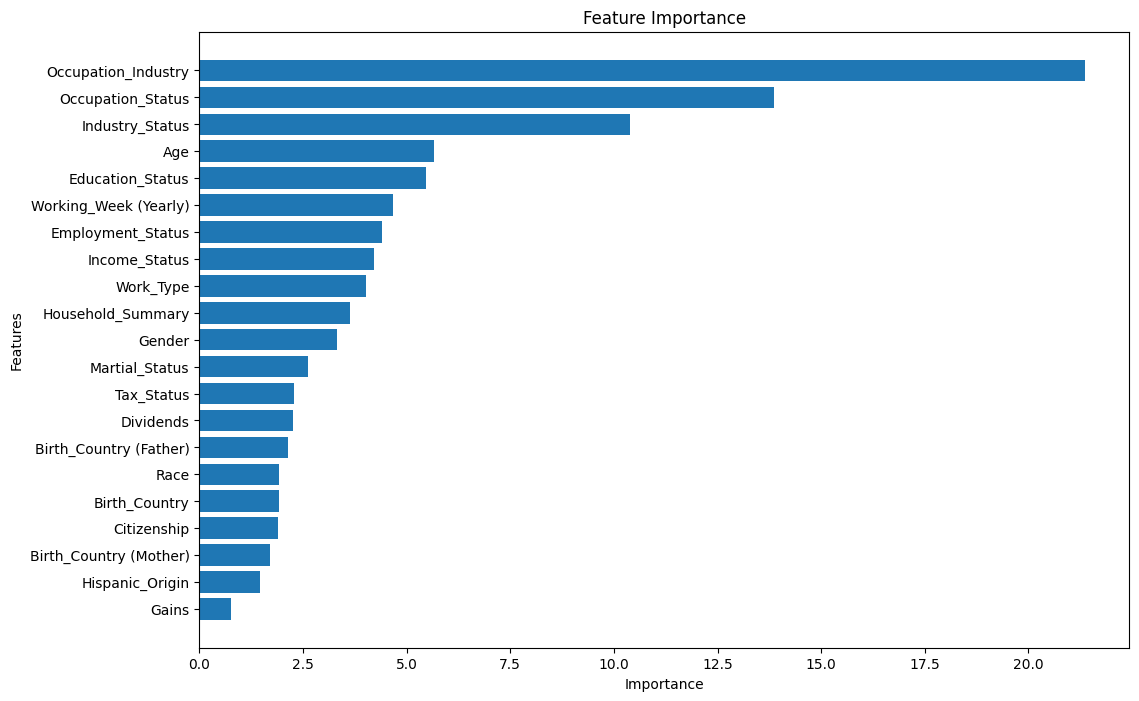

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature importance를 가져옵니다.
feature_importances = final_model.get_feature_importance()

# 특성 이름을 가져옵니다.
feature_names = X_train.columns

# Feature importance를 DataFrame으로 변환합니다.
fi_df = pd.DataFrame({'Features': feature_names, 'Importance': feature_importances})

# Importance 값에 따라 내림차순으로 정렬합니다.
fi_df = fi_df.sort_values(by='Importance', ascending=False)

# Feature importance를 시각화합니다.
plt.figure(figsize=(12, 8))
plt.barh(fi_df['Features'], fi_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # 중요도가 높은 특성을 위로
plt.show()


In [ ]:
# test 데이터에 대해 예측
predictions = final_model.predict(test_data)

# 음수 예측값을 0으로 대체
predictions = np.maximum(0, predictions)

# submission
submission = pd.read_csv('/content/drive/MyDrive/소득 예측/sample_submission.csv')
submission['Income'] = predictions
submission.to_csv('submission_소득예측.csv', index=False)

from google.colab import files
files.download('submission_소득예측.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>